In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from prettyplotlib import *
plt.rcParams['figure.figsize'] = (14,8)

In [60]:
data_files = glob.glob("*.csv")

In [100]:
def read_perf_data(file_name):
    perf_data = {}
    IPCs = {'CPU4':[], 'CPU5':[], 'CPU6':[], 'CPU7':[]}
#     Instructions = {'CPU4':[], 'CPU5':[], 'CPU6':[], 'CPU7':[]}
    alt_IPC = {'CPU4':[], 'CPU5':[], 'CPU6':[], 'CPU7':[]}
    Branches = {'CPU4':[], 'CPU5':[], 'CPU6':[], 'CPU7':[]}
    LLC_misses = {'CPU4':[], 'CPU5':[], 'CPU6':[], 'CPU7':[]}
    with open(file_name, 'r') as f:
        for line in f:
            if 'CPU' in line and line.strip()[0].isdigit():
                cpu = line.strip().split(',')[1]
                if 'cycles' in line:
                    alt_IPC[cpu].append(1/float(line.strip().split(',')[2]))
                elif 'insn per cycle' in line:
                    IPCs[cpu].append(float(line.strip().split(',')[7]))
                    alt_IPC[cpu][-1] *= (float(line.strip().split(',')[2]))
                elif 'branch-misses' in line:
                    Branches[cpu].append(float(line.strip().split(',')[2]))
                elif 'LLC-load-misses' in line:
                    LLC_misses[cpu].append(float(line.strip().split(',')[2]))
                
    perf_data['IPC'] = IPCs
    perf_data['branch-misses'] = Branches
    perf_data['LLC-load-misses'] = LLC_misses
    perf_data['IPC_alt'] = alt_IPC
#     {cpu:(np.array(Instructions[cpu]) / np.array(Cycles[cpu]))\
#                             for cpu in Instructions}
#     print([len(r['CPU7']) for key, r in perf_data.items()])
    
    return perf_data

def plot_counter(perf_data, counter_names, cpu_names, show=True, normalize=False):
    if len(counter_names) == 0 or len(cpu_names) == 0:
        print("Error: no counter names or cpu names supplied")
        return
    for counter in counter_names:
        if counter not in perf_data:
            print("Error: {} not in supplied data.".format(counter))
            continue
        for cpu in cpu_names:
            if cpu not in perf_data[counter]:
                print("Error: {} not in supplied data for counter {}.".format(cpu, counter))
                continue
            if not normalize:
                plt.plot(perf_data[counter][cpu], label="{}: {}".format(cpu, counter))
            else:
                temp = np.array(perf_data[counter][cpu])
                temp /= temp.max()
                plt.plot(temp, label="{}: {}".format(cpu, counter))
            plt.hold(True)
    plt.legend()
    if show:
        plt.hold(False)
        plt.show()



In [101]:
# read the data
series_data = [read_perf_data(x) for x in data_files]

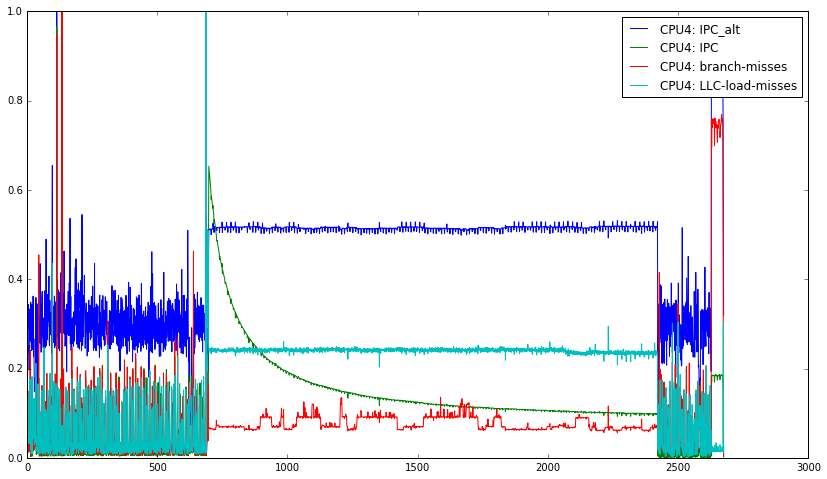

In [105]:
# plot the data for CPU4 IPC for both benchmarks
counters = ['IPC_alt','IPC','branch-misses', 'LLC-load-misses']
cpus = ['CPU4']
plot_counter(series_data[0], counters, cpus, show=True, normalize=True)

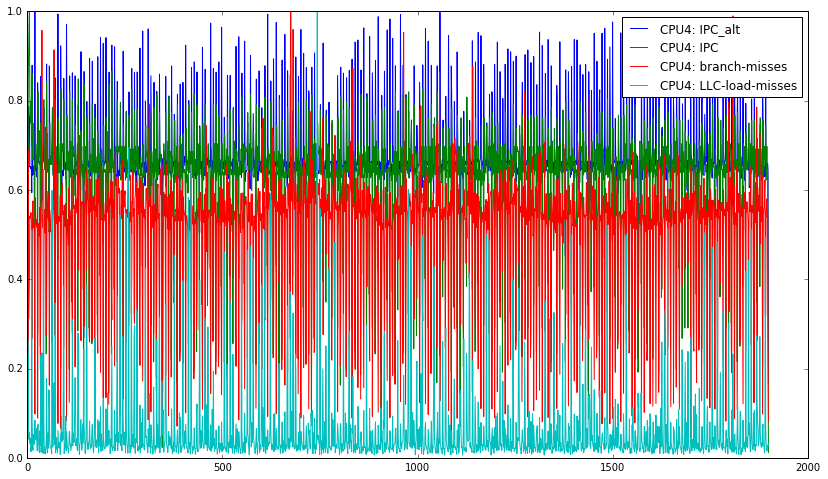

In [104]:
plot_counter(series_data[1], counters, cpus, show=True, normalize=True)